In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import timedcall
from sklearn.decomposition import PCA
from kneed import KneeLocator
from itertools import combinations
from sklearn.metrics import silhouette_score, silhouette_samples
import random
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture as GMM


pd.set_option('display.max_columns', 0)

import warnings
warnings.filterwarnings(action='ignore')

In [66]:
# Get an accuracy for each models for each dataset using each scaling method.
sse = []
sil_avg_n_clusters = []

In [67]:
def data_reading():
    # Read dataset
    df = pd.read_csv("data/housing.csv")
    # Check dataframe
    print("\n------------------------ Data describe ------------------------\n")
    print(df.head())
    return df

In [68]:
def preprocessing(dataset, encoder, scaling, encode_feature_list):
    dataset_copy = dataset.copy()
    # If 'categorical feature' exists, scaling after encoder
    if encode_feature_list is not None:
        dataset_copy = object_encoder(dataset_copy, encoder, encode_feature_list)
    dataset_copy = data_scaling(dataset_copy, scaling)

    return dataset_copy

In [69]:
# Categorical feature need to change numeric
# Encoder
def object_encoder(dataframe, encoder, target_feature):
    # For LabelEncoder
    if encoder == "LabelEncoder" or encoder == "LabelEncoder()":
        encoder = LabelEncoder()
        for i in target_feature:
            dataframe[i] = encoder.fit_transform(dataframe[i])

    # For Ordinal Encoder
    elif encoder == "OrdinalEncoder" or encoder == "OrdinalEncoder()":
        encoder = OrdinalEncoder()
        encoder.fit(dataframe[target_feature])
        dataframe[target_feature] = encoder.transform(dataframe[target_feature])

    # For encoder is None
    elif encoder is None:
        return dataframe

    # Returns None for error message output if not the above 3 types of values
    else:
        return None

    return dataframe

In [70]:
# Scaling
def data_scaling(dataframe, scaling):
    # Perform scaling according to the scaler, respectively
    if scaling == "StandardScaler" or scaling == "StandardScaler()":
        scaling = StandardScaler()
    elif scaling == "MinMaxScaler" or scaling == "MinMaxScaler()":
        scaling = MinMaxScaler()
    elif scaling == "RobustScaler" or scaling == "RobustScaler()":
        scaling = RobustScaler()
    elif scaling is None:
        return dataframe

    # Returns None for error message output if not the above 6 types of values
    else:
        return None

    dataframe = pd.DataFrame(scaling.fit_transform(dataframe), columns=dataframe.columns)
    return dataframe

In [71]:
def K_means_plot(df):
    cluster_lists = [2, 4, 6, 8, 10]
    # Because of the large number of features, we use pca to reduce dimensions
    pca = PCA(2)
    df = pca.fit_transform(df)

    num_clu = len(cluster_lists)

    # Create axs that has as many sub-figure as the number of clusters in the cluster list
    fig, axs = plt.subplots(figsize=(4 * num_clu, 4), nrows=1, ncols=num_clu)
    fig.subplots_adjust(top=1.0)

    for n, n_cluster in enumerate(cluster_lists):
        model = KMeans(n_clusters = n_cluster, max_iter=500, random_state=43)
        kmeans_labels = model.fit_predict(df)
        axs[n].set_title('Number of Cluster : '+ str(n_cluster)+'\n')

        # By using unique label, plot the input data
        unique_labels = np.unique(kmeans_labels)
        centroids = model.cluster_centers_
        for i in unique_labels:
            axs[n].scatter(df[kmeans_labels == i, 0], df[kmeans_labels == i, 1], label=i)


        # Labeling to distinguish clusters and write numbers each of cluster's center
        axs[n].scatter(centroids[:, 0], centroids[:, 1], marker='o',
                    c="red", alpha=1, s=100, edgecolor='k')
        for i, c in enumerate(centroids):
            axs[n].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=25, edgecolor='k')
    # plt.suptitle(fontsize=12, fontweight='bold', y=0.98)
    plt.show()

In [72]:
# draw elbow plot
def elbowPlot():

    # k from 2 to 10 by 2 intervals
    kl = KneeLocator(
        range(2, 11, 2), sse, curve="convex", direction="decreasing"
    )
    kl.plot_knee()

    plt.show()

    print('The elbow point is ', kl.elbow)

In [73]:
# A function that visualizes the area of each silhouette coefficient of the number of clusters
def kmeans_cluster(X_features, scaler):


    cluster_lists = [2, 4, 6, 8, 10]

    sse.clear()
    sil_avg_n_clusters.clear()

    # The number of clustering is received as an input value.
    n_cols = len(cluster_lists)


    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    fig.subplots_adjust(top=0.8)

    # Visualize silhouette scores using euclidean distance by repeating as the number of clusters
    for n, n_cluster in enumerate(cluster_lists):
        # Perform k means clustering
        cluster_km = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = cluster_km.fit_predict(X_features)
        sse.append(cluster_km.inertia_)

        # Using euclidean distance
        sil_avg = silhouette_score(X_features, cluster_labels, metric='euclidean')
        sil_values = silhouette_samples(X_features, cluster_labels)
        sil_avg_n_clusters.append(sil_avg)

        y_lower = 10
        axs[n].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score \nusing euclidean distance :' + str(round(sil_avg,3)) )
        axs[n].set_xlabel("The silhouette coefficient values")
        axs[n].set_ylabel("Cluster label")
        axs[n].set_xlim([-0.1, 1])
        axs[n].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[n].set_yticks([])  # Clear the yaxis labels / ticks
        axs[n].set_xticks([0, 0.25, 0.5, 0.75, 1])

        # Bar graph representation by number of cluster
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[n].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

    sse.clear()
    sil_avg_n_clusters.clear()

    # Visualize silhouette scores using manhattan distance by repeating as the number of clusters
    for n, n_cluster in enumerate(cluster_lists):
        # Perform k means clustering
        cluster_km = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = cluster_km.fit_predict(X_features)
        sse.append(cluster_km.inertia_)

        # Using euclidean distance
        sil_avg = silhouette_score(X_features, cluster_labels, metric='manhattan')
        sil_values = silhouette_samples(X_features, cluster_labels)
        sil_avg_n_clusters.append(sil_avg)

        y_lower = 10
        axs[n].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score \nusing manhattan distance :' + str(round(sil_avg,3)) )
        axs[n].set_xlabel("The silhouette coefficient values")
        axs[n].set_ylabel("Cluster label")
        axs[n].set_xlim([-0.1, 1])
        axs[n].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[n].set_yticks([])  # Clear the yaxis labels / ticks
        axs[n].set_xticks([0, 0.25, 0.5, 0.75, 1])

        # Bar graph representation by number of cluster
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[n].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10


        axs[n].axvline(x=sil_avg, color="red", linestyle="-")
    plt.suptitle(scaler, fontsize=12, fontweight='bold', y=0.98)
    plt.show()

    elbowPlot()
    K_means_plot(X_features)

In [74]:
def gmm_silhouette(cluster_lists, X_features, scaler):




    sse.clear()
    sil_avg_n_clusters.clear()

    # Visualize the silhouette coefficient of each cluster by area
    n_cols = len(cluster_lists)


    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    fig.subplots_adjust(top=0.8)

    # Visualize silhouette scores using euclidean distance by repeating as the number of clusters
    for n, n_cluster in enumerate(cluster_lists):

        # Perform GMM clustering
        clusterer = GMM(n_components = n_cluster, max_iter=200, random_state=1)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels, metric='euclidean')
        sil_values = silhouette_samples(X_features, cluster_labels)
        sil_avg_n_clusters.append(sil_avg)

        y_lower = 10
        axs[n].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score \nusing euclidean distance:' + str(round(sil_avg,3)) )
        axs[n].set_xlabel("The silhouette coefficient values")
        axs[n].set_ylabel("Cluster label")
        axs[n].set_xlim([-0.1, 1])
        axs[n].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[n].set_yticks([])  # Clear the yaxis labels / ticks
        axs[n].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # Bar graph representation by number of cluster
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[n].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

    sse.clear()
    sil_avg_n_clusters.clear()

    # Visualize silhouette scores using manhattan distance by repeating as the number of clusters
    for n, n_cluster in enumerate(cluster_lists):

        # Perform GMM clustering
        clusterer = GMM(n_components = n_cluster, max_iter=200, random_state=1)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels, metric='manhattan')
        sil_values = silhouette_samples(X_features, cluster_labels)
        sil_avg_n_clusters.append(sil_avg)

        y_lower = 10
        axs[n].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score \nusing manhattan distance:' + str(round(sil_avg,3)) )
        axs[n].set_xlabel("The silhouette coefficient values")
        axs[n].set_ylabel("Cluster label")
        axs[n].set_xlim([-0.1, 1])
        axs[n].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[n].set_yticks([])  # Clear the yaxis labels / ticks
        axs[n].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # Bar graph representation by number of cluster
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[n].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10


        axs[n].axvline(x=sil_avg, color="red", linestyle="-")
    plt.suptitle(scaler, fontsize=12, fontweight='bold', y=0.98)
    plt.show()

In [75]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap=plt.cm.get_cmap('rainbow', 200), zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

In [76]:
def em_cluster(df, scaler):
    from sklearn.mixture import GaussianMixture as GMM
    import matplotlib.pyplot as plt


    # Because of the large number of features, pca is used to reduce dimensions
    pca = PCA(2, whiten=True)
    df = pca.fit_transform(df)
    n_components = np.arange(40, 220, 20)

    # use BIC model
    models = [GMM(n, covariance_type='full', random_state=43) for n in n_components]
    bics = [model.fit(df).bic(df) for model in models]

    plt.plot(n_components, bics)
    plt.xlabel('Number of Components')
    plt.ylabel('BIC')
    plt.title('BIC for the number of GMM components')
    plt.axhline(y=min(bics), color="red", linestyle="-")
    plt.show()

    gmm = GMM(n_components[bics.index(min(bics))], covariance_type='full', random_state=1)
    gmm.fit(df)

    gmm_silhouette(range(2,11,2), df, scaler)

    plot_gmm(gmm, df)
    plt.title('{} & GMM Clustering with n_components :{}'.format(scaler, gmm.n_components))
    plt.show()

In [77]:
def DBSCAN_cluster(df,scaler):
    #eps와 min_sample 설정
    db = DBSCAN(eps=0.5, min_samples=5).fit(df)
    labels = db.labels_

    #using db lable, make bool array, and change outlier into False
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    #visualization
    unique_labels = set(labels)


    for k in unique_labels:
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

            # 클러스터들의 데이터를 화면에 그린다.
        xy = df[class_member_mask & core_samples_mask]
        plt.scatter(xy.iloc[:, 0], xy.iloc[:, 1], s=20,  marker=u'o', alpha=0.5)

        # Outlier를 그린다.
        xy = df[class_member_mask & ~core_samples_mask]
        plt.scatter(xy.iloc[:, 0], xy.iloc[:, 1], s=20, marker=u'o', alpha=0.5)
    plt.title("DBSCAN cluster {}".format(scaler))
    plt.show()

In [78]:
def clarans_cluster(df, scaler):
    tmp_dataset = df.copy()

    # Because of the large number of features, pca is used to reduce dimensions
    pca = PCA(n_components=2)  # Reduce feature for plotting
    tmp_dataset = pd.DataFrame(pca.fit_transform(tmp_dataset))

    tuple_data = tmp_dataset.values.tolist()

    k_range = [2, 4, 6, 8, 10]

    for k in k_range:
        clarans_instance = clarans(tuple_data, k, 3, 2)
        print('start')
        (ticks, result) = timedcall(clarans_instance.process);
        print("Execution time : ", ticks, "\n");

        # return the cluster
        clusters = clarans_instance.get_clusters()

        # return the mediods
        medoids = clarans_instance.get_medoids()

        # visualization
        vis_clusters = []

        for i in range(0, len(df)):
            for j in range(len(clusters)):
                if i in clusters[j]:
                    vis_clusters.append(j)

        vis_clusters = np.array(vis_clusters)
        vis_medoids = []

        for i in range(0, len(medoids)):
            vis_medoids.append(df[medoids[i]])

        vis_medoids = np.array(vis_medoids)

        for i in range(k):
            cluster_name = "Claren Cluster {}".format(i + 1)
            plt.scatter(df[vis_clusters == i, 0], df[vis_clusters == i, 1], s=10, label=cluster_name)

        plt.scatter(vis_medoids[:, 0], vis_medoids[:, 1], s=50, c='red', label='Centroids')
        plt.suptitle(scaler, fontsize=12, fontweight='bold', y=0.98)
        plt.legend()
        plt.show()

In [79]:
def auto_ml(input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists, k_lists=None):
    # copy dataset
    global dataset_x_encode
    dataset = input_dataset.copy()
    dataset_x = dataset.drop(columns="median_house_value")
    data_category = None
    dataset_x.dropna()

    # Verify that model_list exists
    contain_model_list = ['em', 'clarans', 'dbscan', 'kmeans' ]
    for i in model_lists:
        if contain_model_list.__contains__(i) is False:
            print(i, "is invalid model.\n")
            return None

    # Verify that encoder_list exists
    contain_encoder_list = [None, 'LabelEncoder', 'OrdinalEncoder']
    for i in encoder_lists:
        if contain_encoder_list.__contains__(i) is False:
            print(i, "is invalid encoder.\n")
            return None

    # Verify that scaling_list exists
    contain_scaling_list = [None, 'StandardScaler', 'MinMaxScaler', 'RobustScaler']
    for i in scaling_lists:
        if contain_scaling_list.__contains__(i) is False:
            print(i, "is invalid scaler.\n")
            return None

    feature_combination_list = []
    numeric_cols = list(input_dataset.columns)
    numeric_cols.remove('ocean_proximity')
    for i in range(4):
        selected_features = random.sample(numeric_cols, i + 2)
        feature_combination_list.append(selected_features)

    for combination in feature_combination_list:
        dataset_x = df[combination]
    data_category = dataset_x.select_dtypes(include='object')


    # Set the count to know the progress because it outputs multiple combinations
    count = 1

    for encoder in encoder_lists:
        for scaler in scaling_lists:
            # preprocessing dataset using scaler & encoder
            if data_category is not None:
                dataset_x_encode = preprocessing(dataset_x, encoder, scaler, data_category).copy()
                if dataset_x_encode is None:
                    print("Error")
                    return 0
            # fit cluster using each model and plotting about each model's parameters
            for model in model_lists:
                print("Combination [" + str(count) + "]:", model, ",", encoder, ",", scaler)
                if model == 'kmeans':
                    kmeans_cluster(dataset_x_encode, scaler)
                elif model == 'em':
                    em_cluster(dataset_x_encode, scaler)
                # elif model == 'clarans':
                #     clarans_cluster(dataset_x_encode, scaler)
                elif model == 'dbscan':
                    DBSCAN_cluster(dataset_x_encode, scaler)

                count += 1


------------------------ Data describe ------------------------

   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]


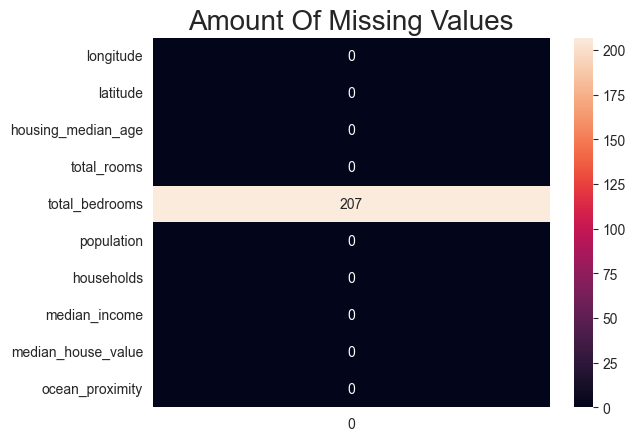


--------------- Drop NAN and check data ---------------

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64
---------- ocean proximity ----------
0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20433, dtype: object

---------- After Encoding ----------
0        3
1        3
2        3
3        3
4        3
        ..
20635    1
20636    1
20637    1
20638    1
20639    1
Name: ocean_proximity, Length: 20433, dtype: int64


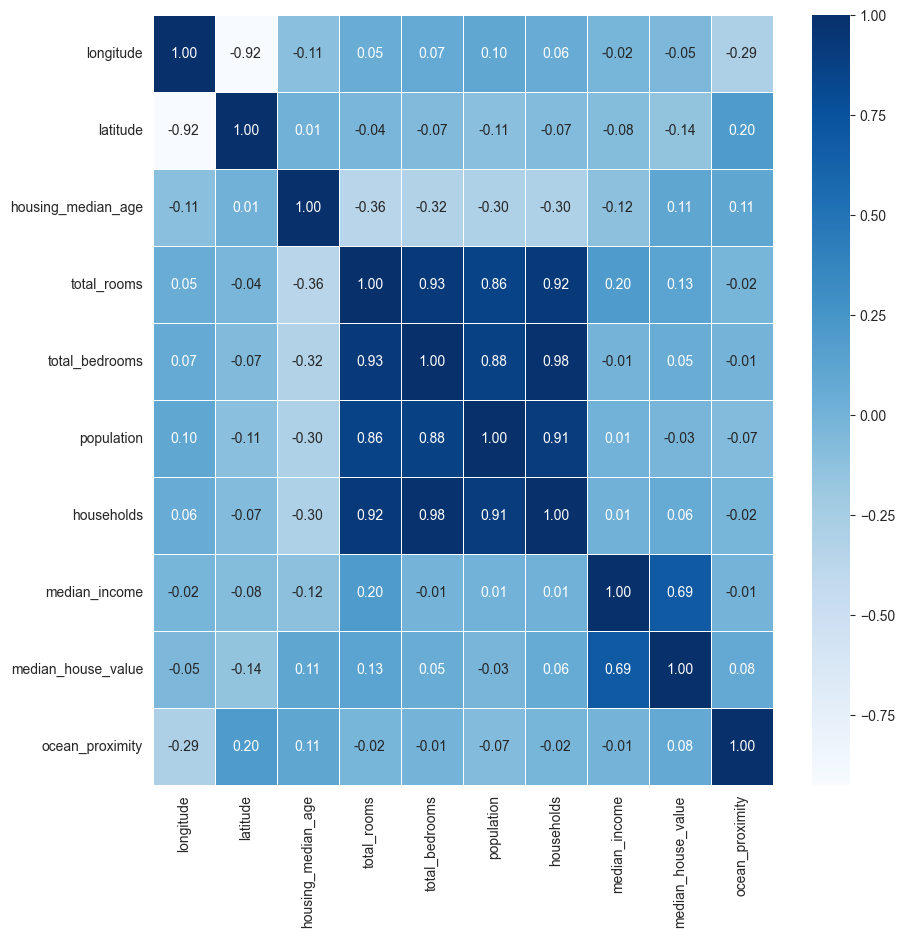

Combination [1]: em , LabelEncoder , StandardScaler


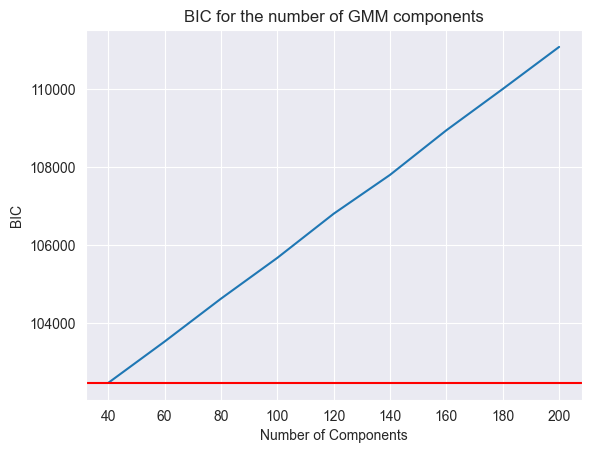

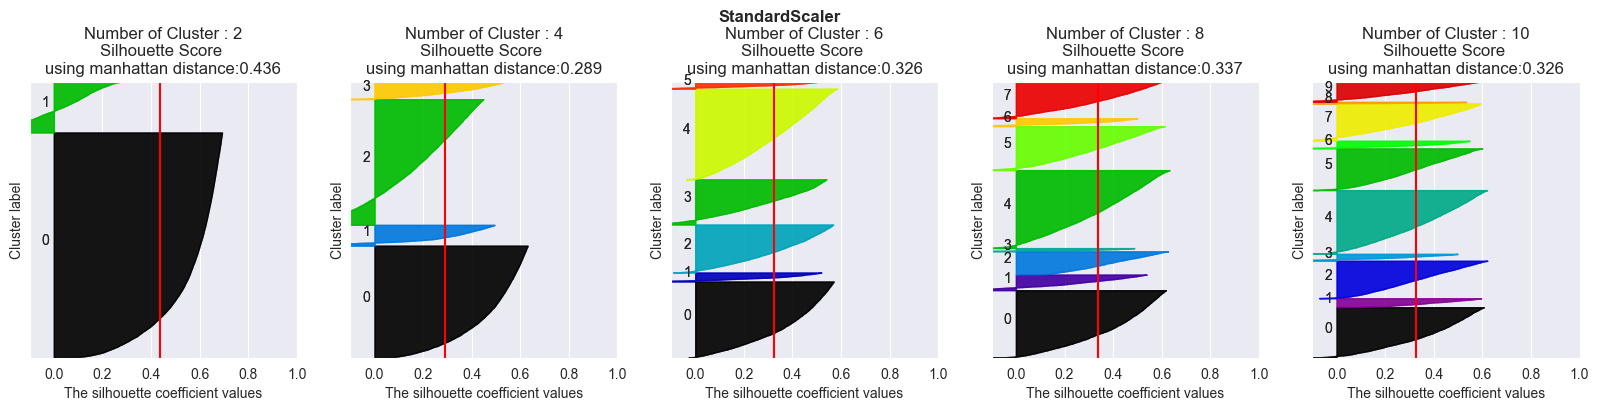

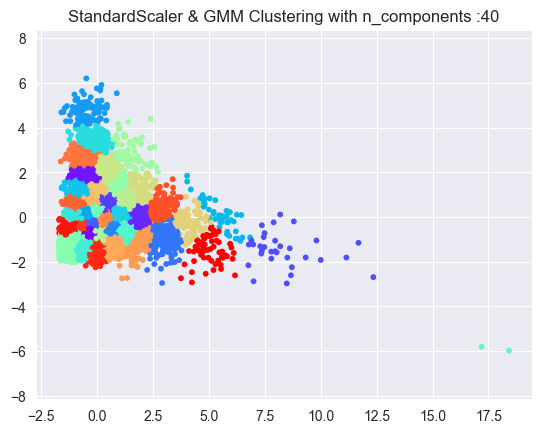

Combination [2]: clarans , LabelEncoder , StandardScaler
Combination [3]: dbscan , LabelEncoder , StandardScaler


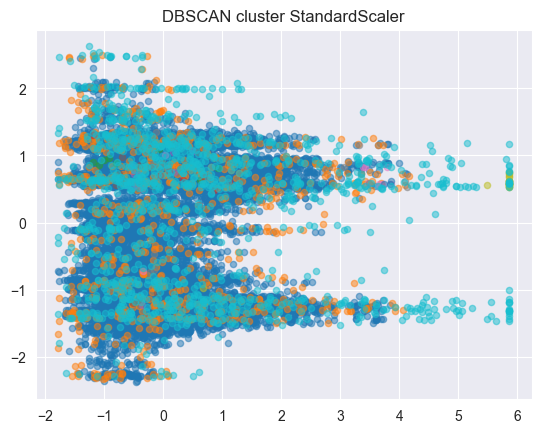

Combination [4]: kmeans , LabelEncoder , StandardScaler


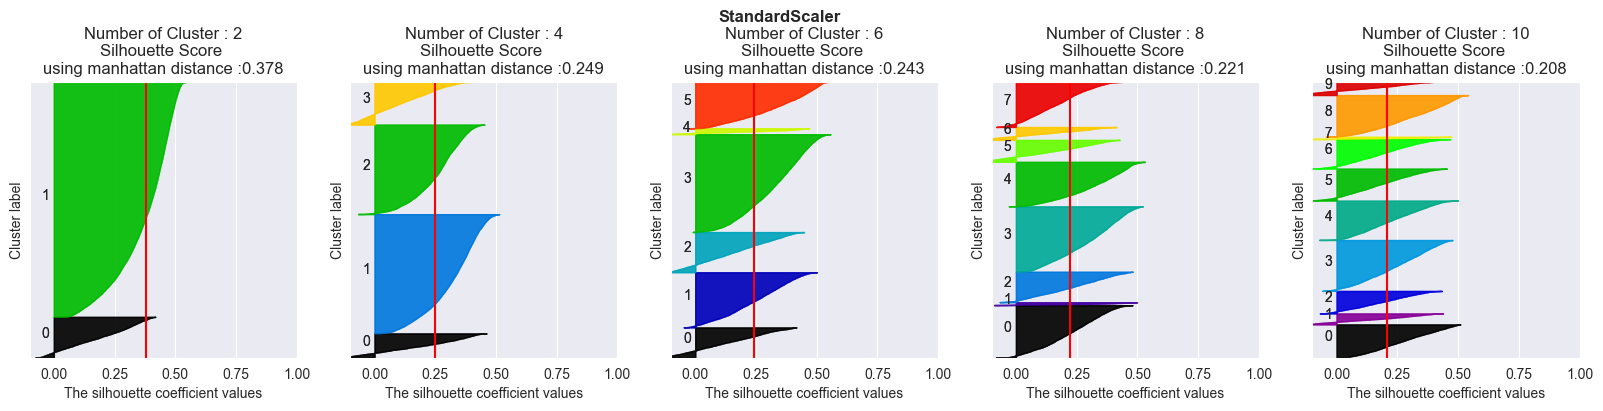

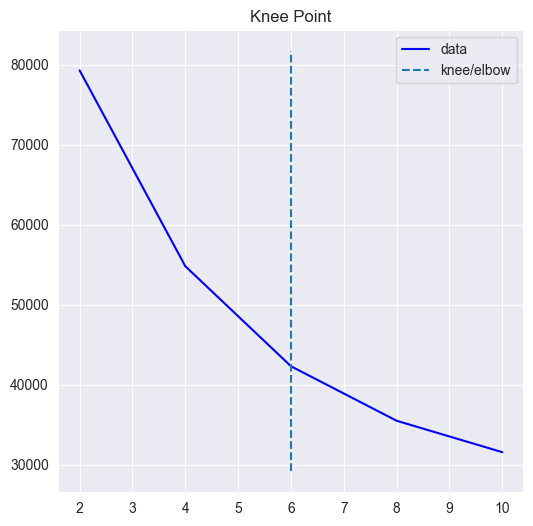

The elbow point is  6


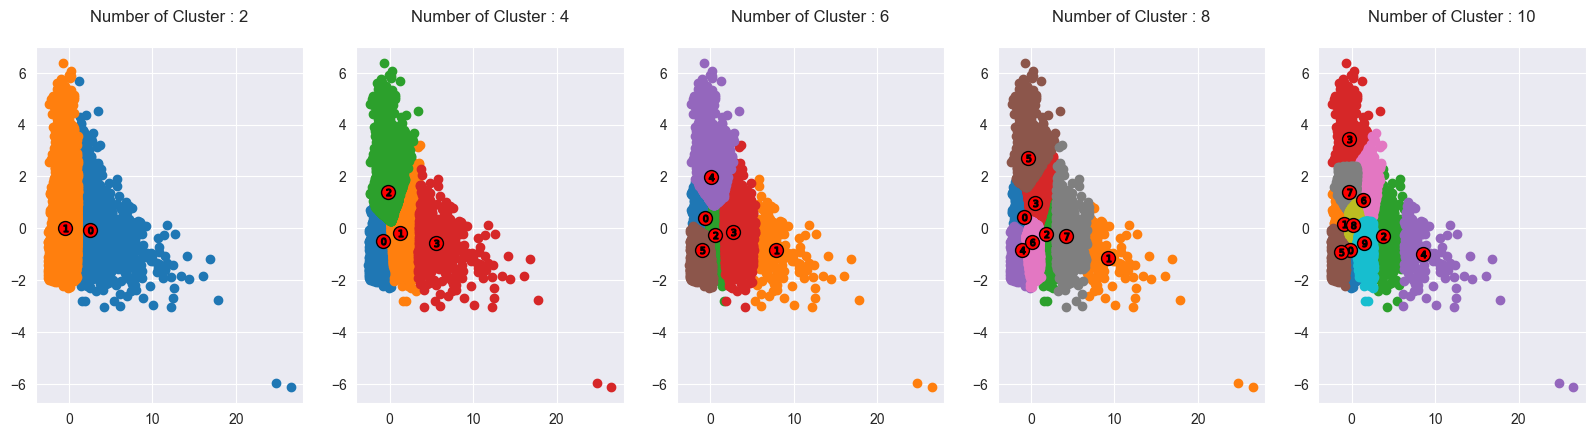

Combination [5]: em , LabelEncoder , MinMaxScaler


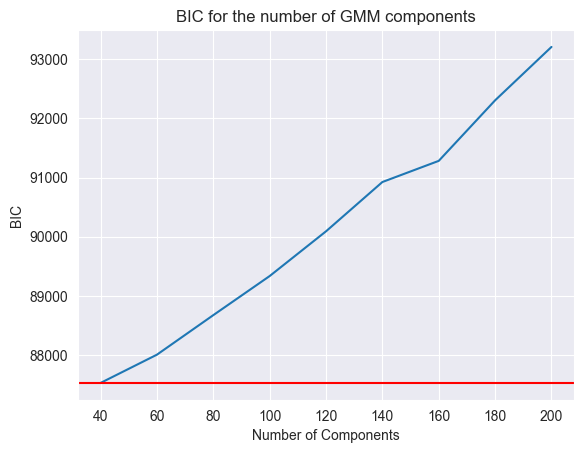

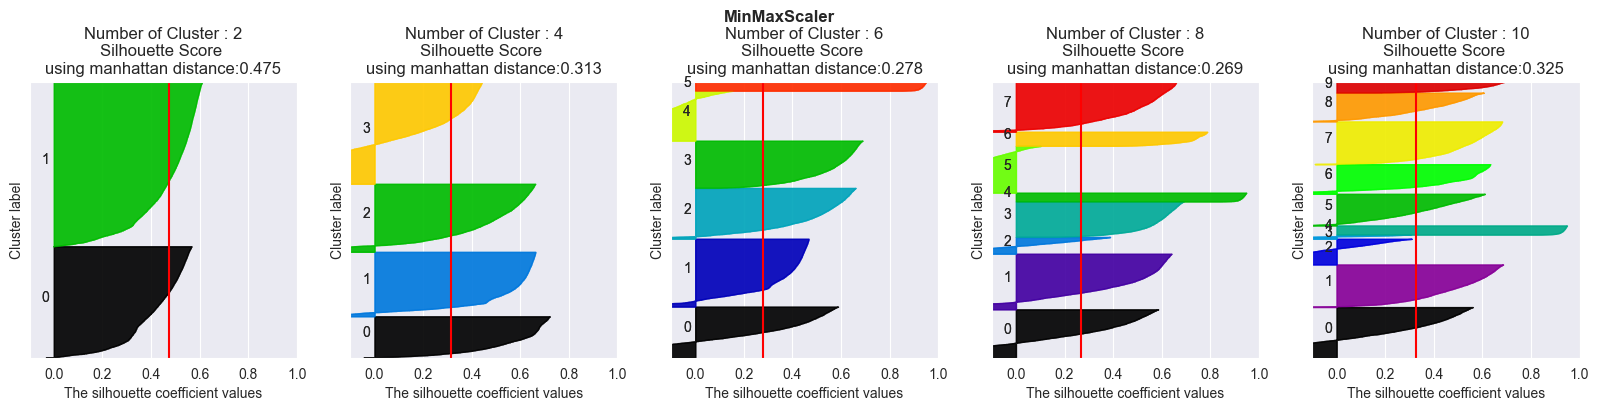

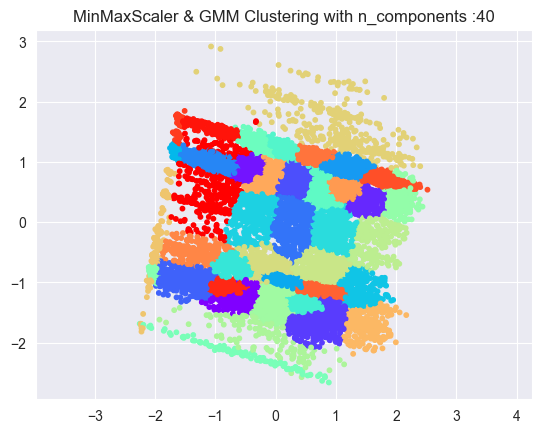

Combination [6]: clarans , LabelEncoder , MinMaxScaler
Combination [7]: dbscan , LabelEncoder , MinMaxScaler


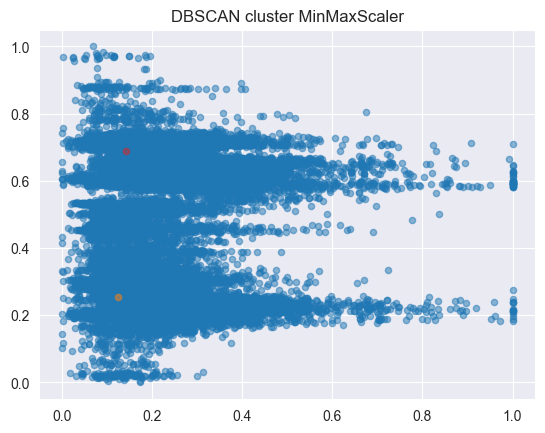

Combination [8]: kmeans , LabelEncoder , MinMaxScaler


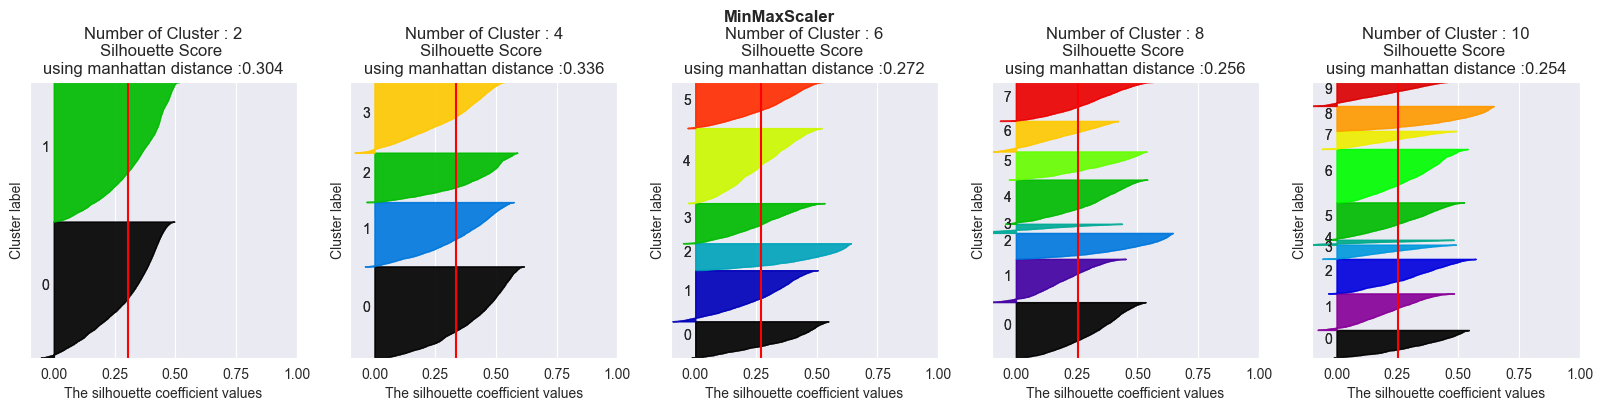

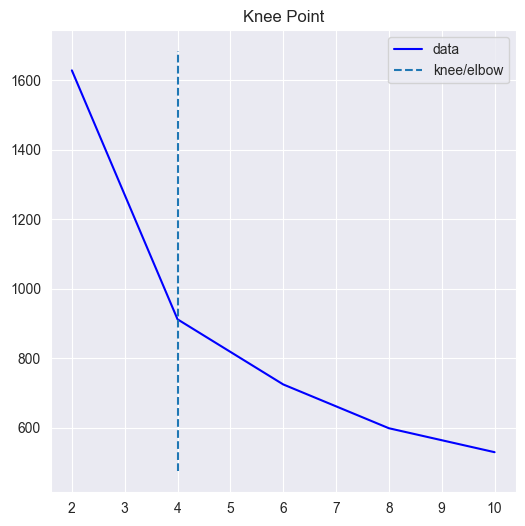

The elbow point is  4


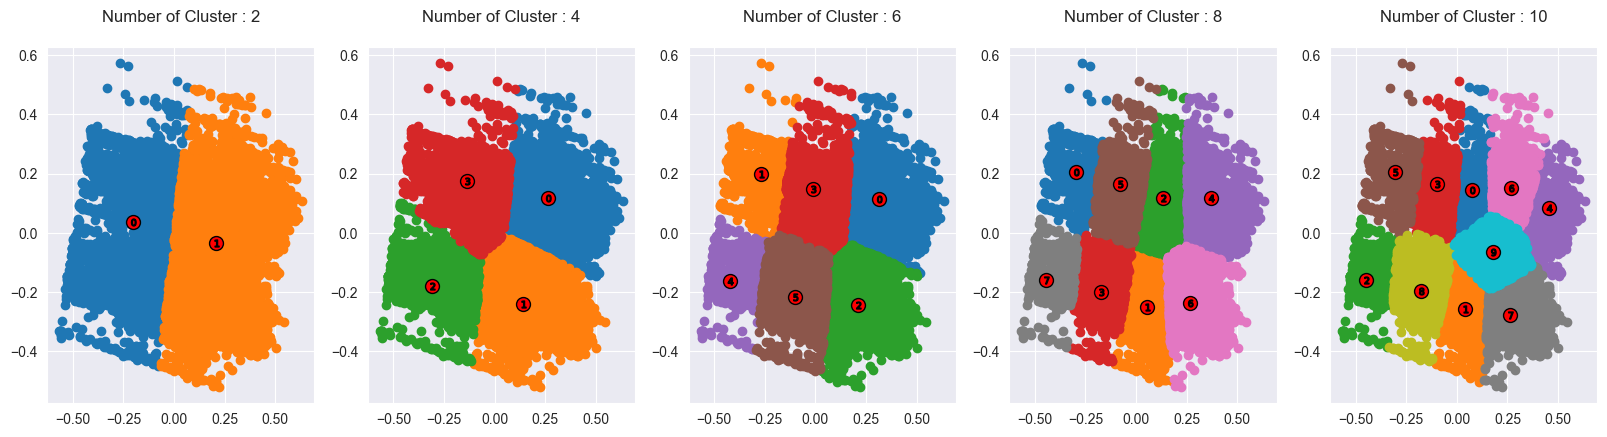

Combination [9]: em , LabelEncoder , RobustScaler


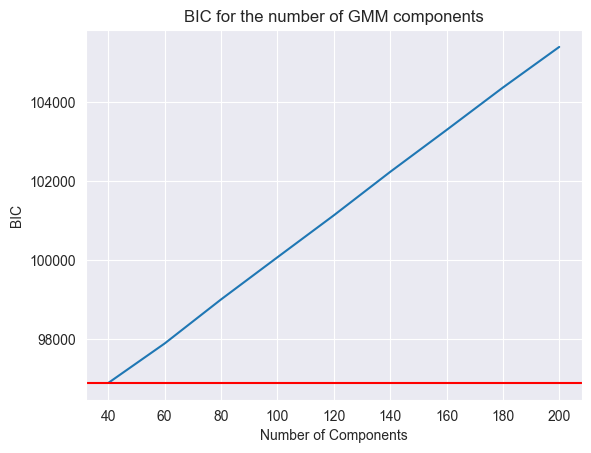

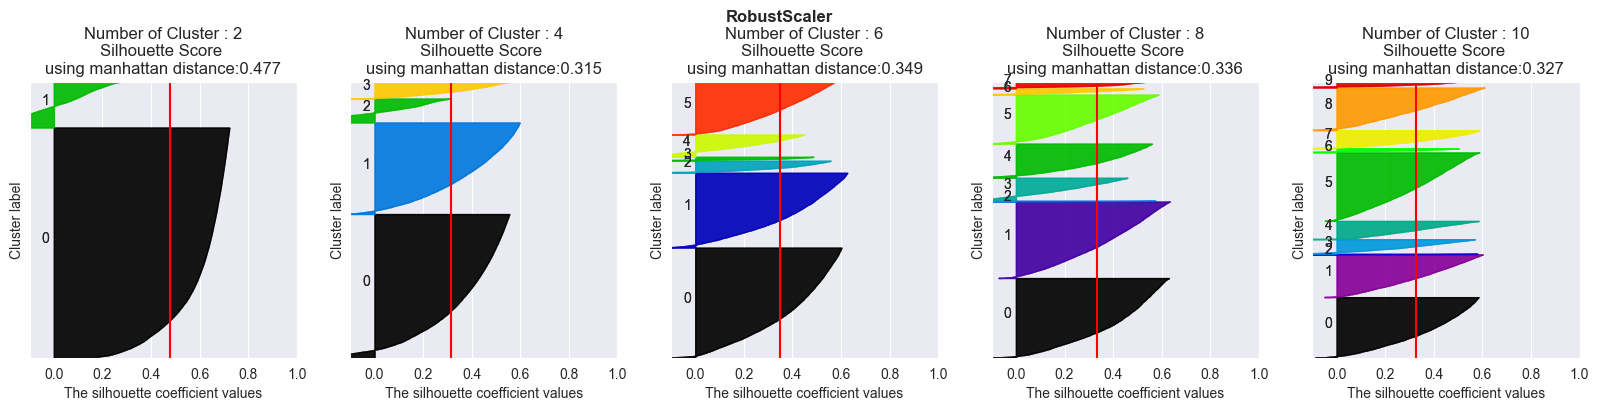

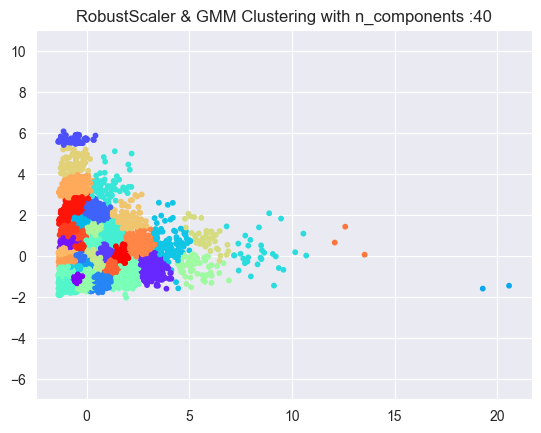

Combination [10]: clarans , LabelEncoder , RobustScaler
Combination [11]: dbscan , LabelEncoder , RobustScaler


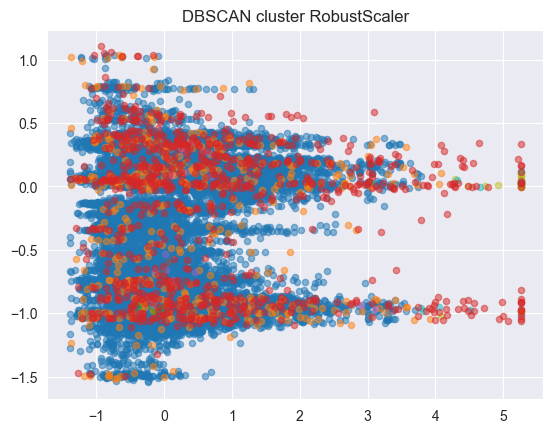

Combination [12]: kmeans , LabelEncoder , RobustScaler


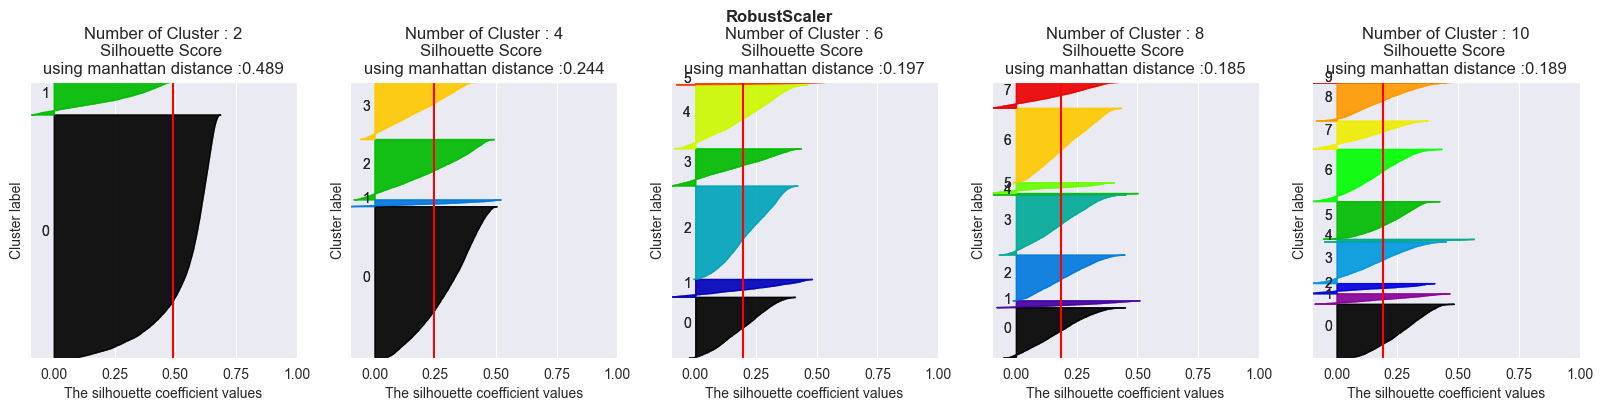

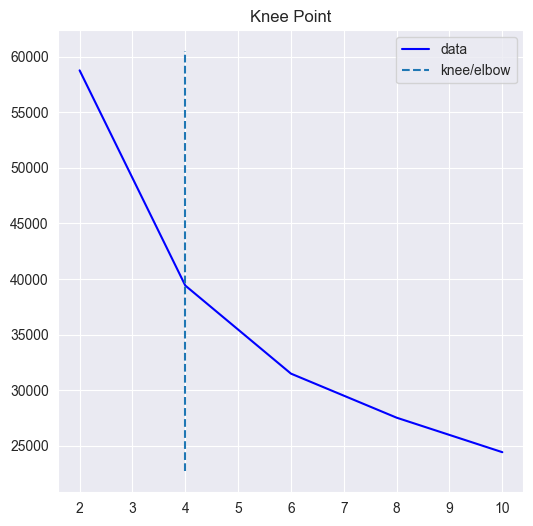

The elbow point is  4


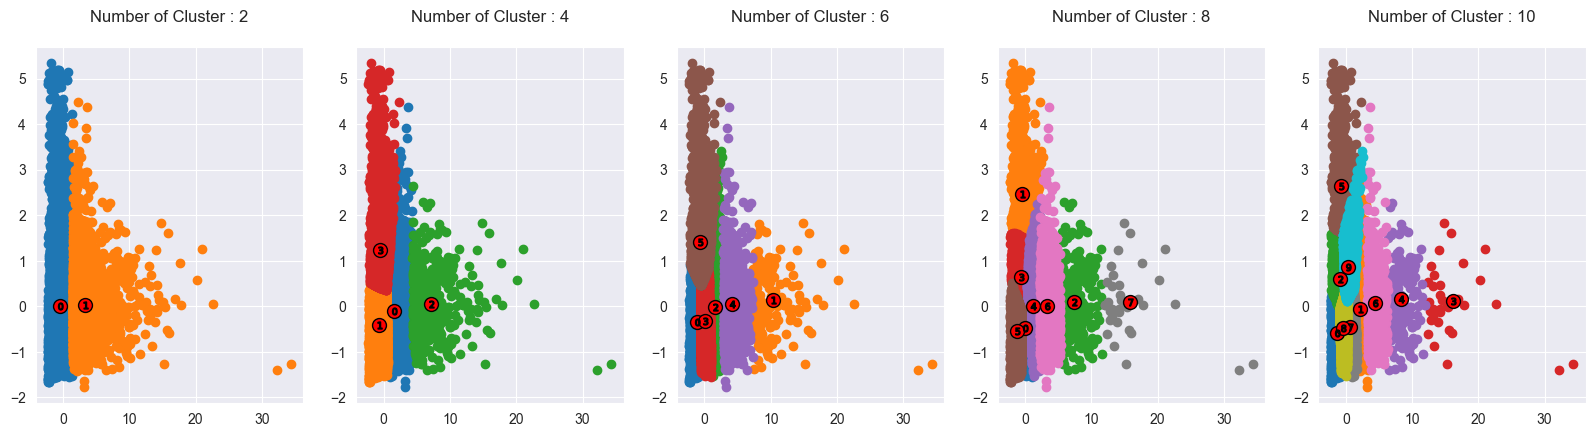

Combination [13]: em , OrdinalEncoder , StandardScaler


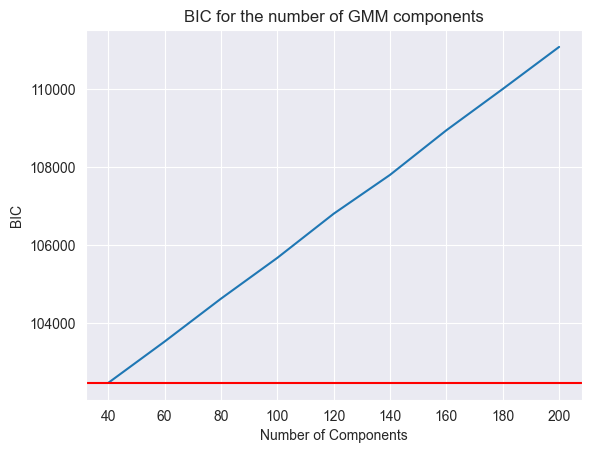

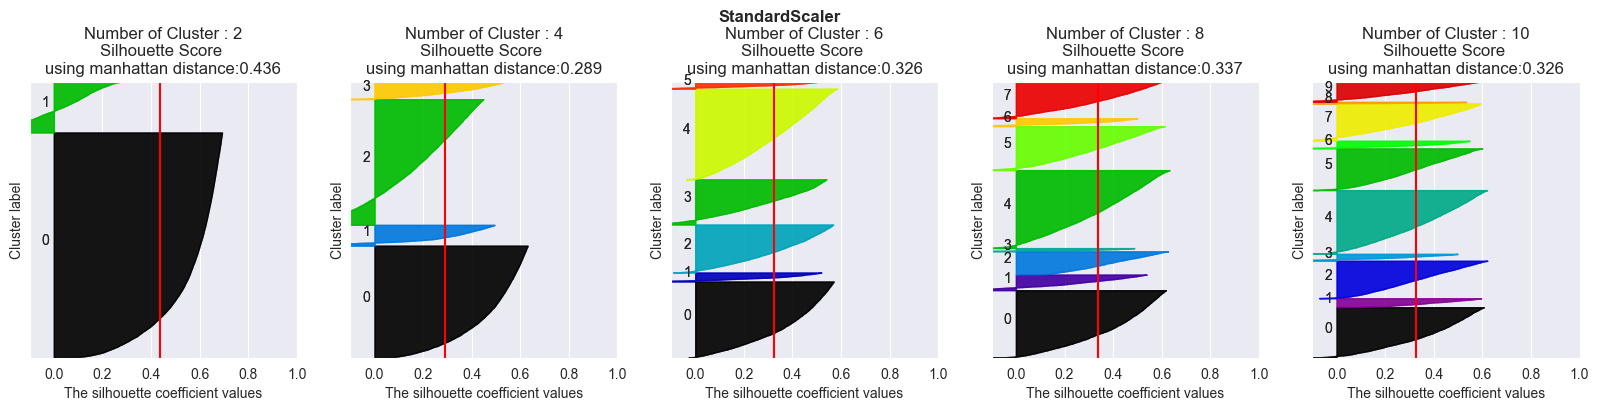

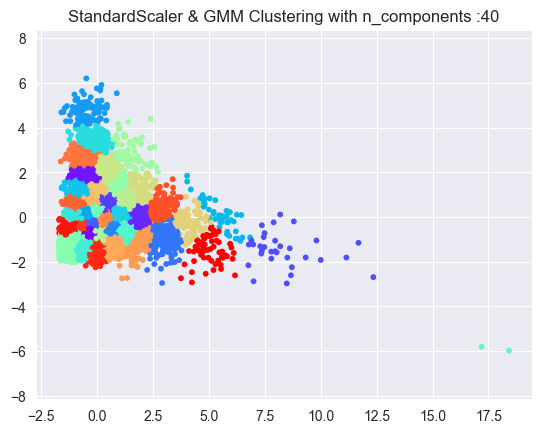

Combination [14]: clarans , OrdinalEncoder , StandardScaler
Combination [15]: dbscan , OrdinalEncoder , StandardScaler


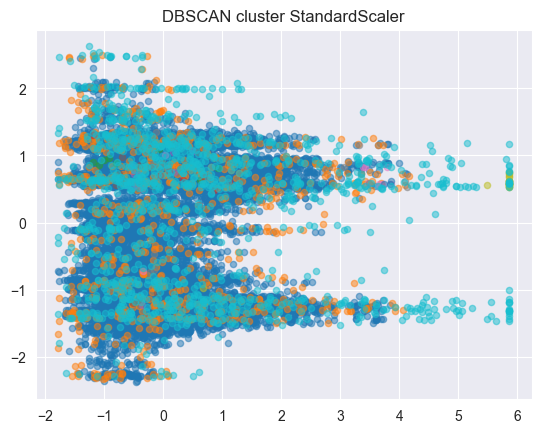

Combination [16]: kmeans , OrdinalEncoder , StandardScaler


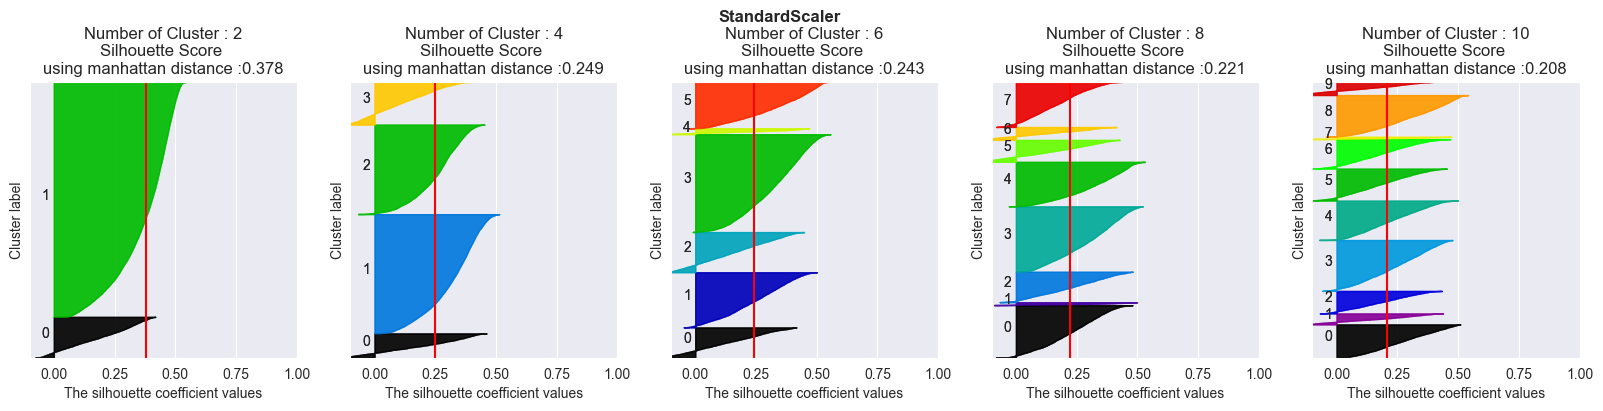

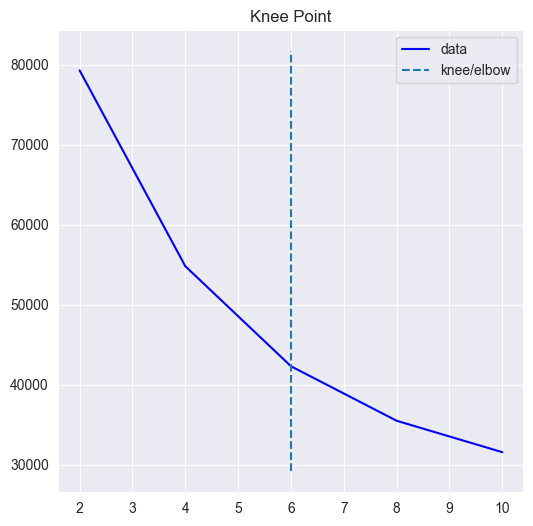

The elbow point is  6


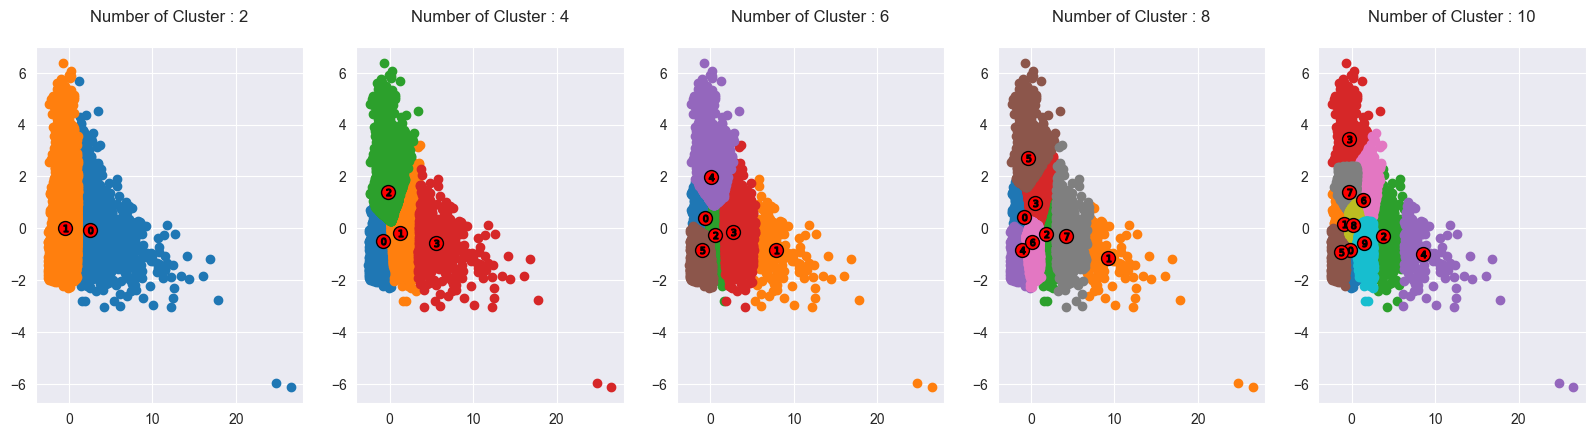

Combination [17]: em , OrdinalEncoder , MinMaxScaler


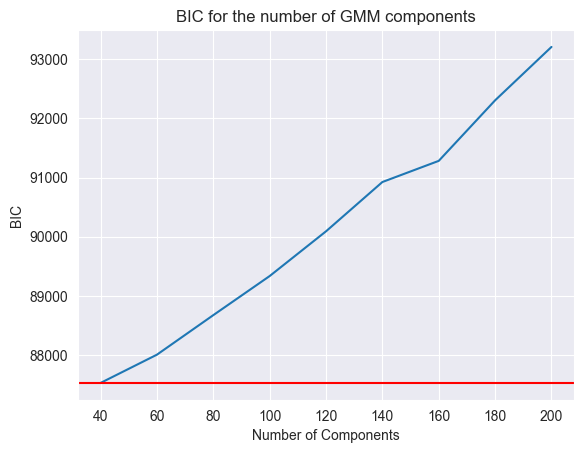

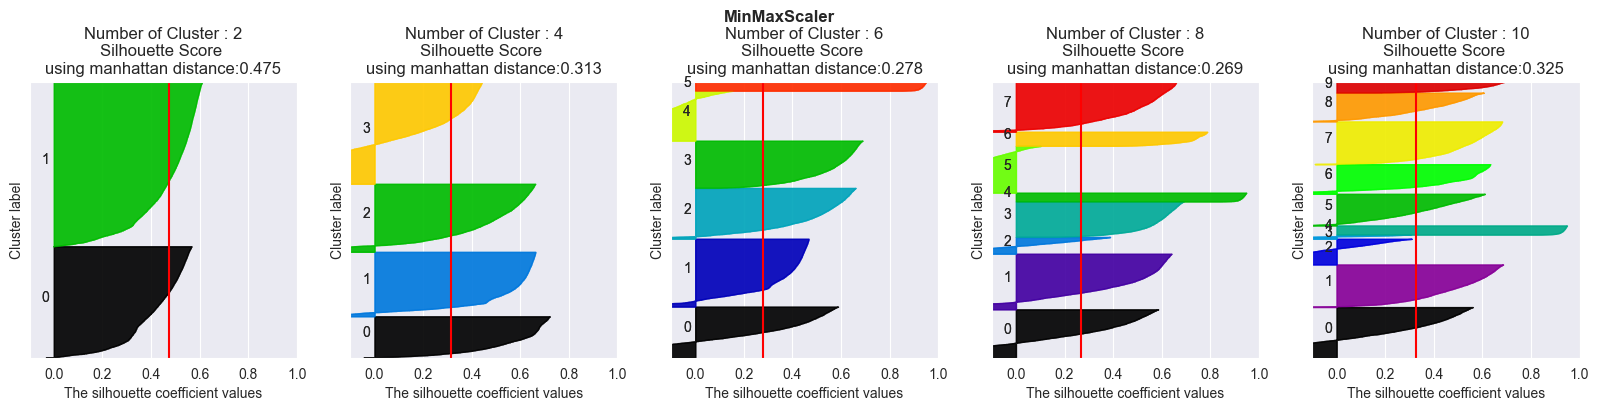

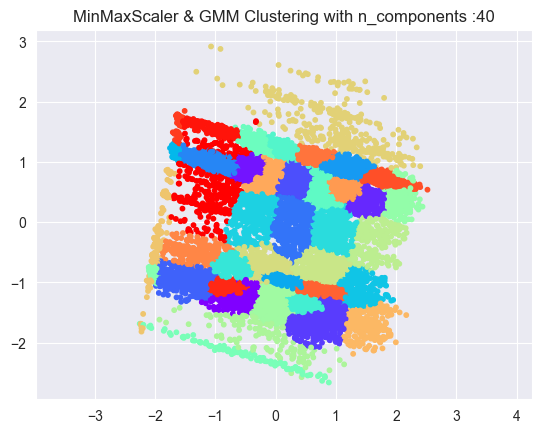

Combination [18]: clarans , OrdinalEncoder , MinMaxScaler
Combination [19]: dbscan , OrdinalEncoder , MinMaxScaler


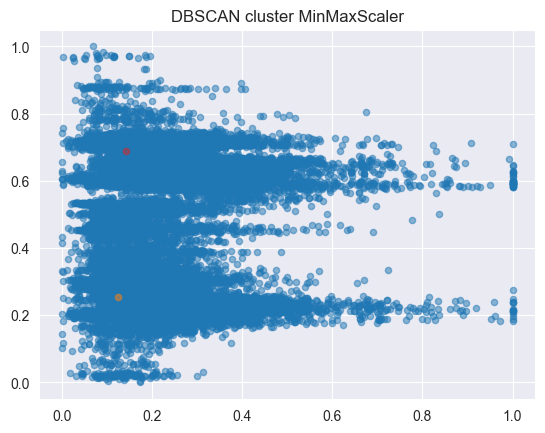

Combination [20]: kmeans , OrdinalEncoder , MinMaxScaler


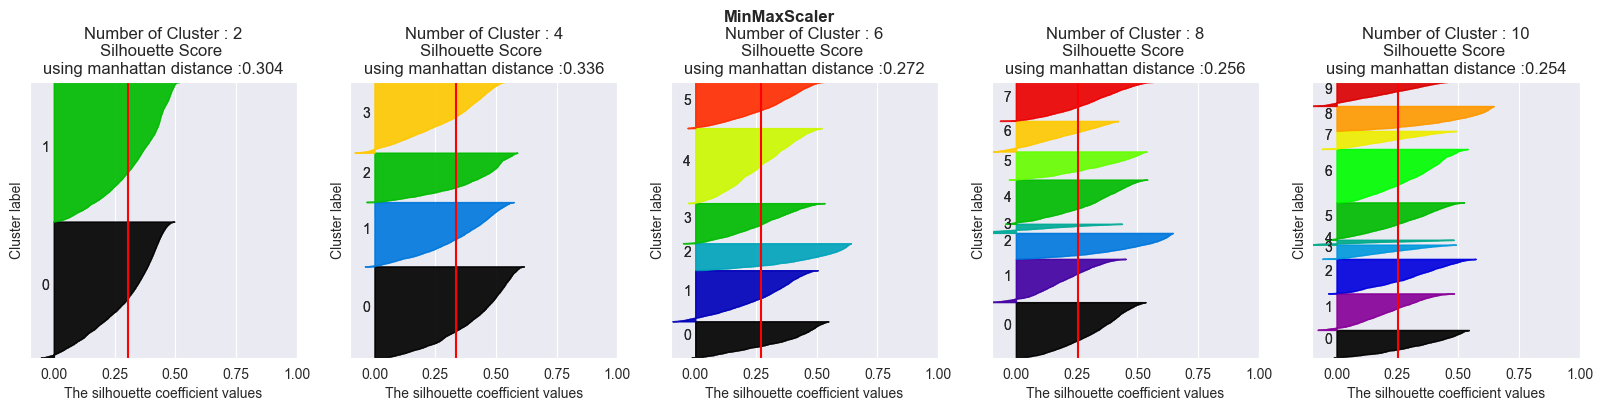

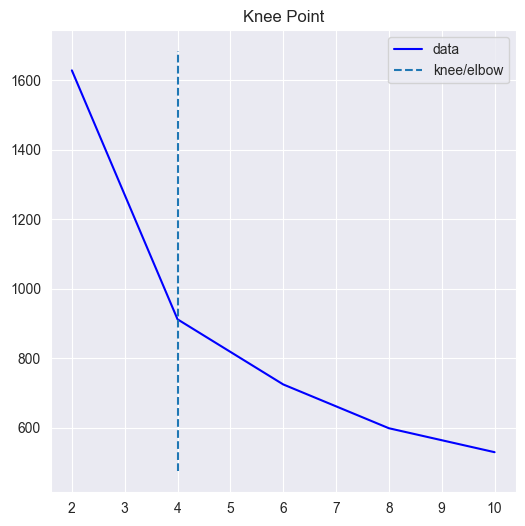

The elbow point is  4


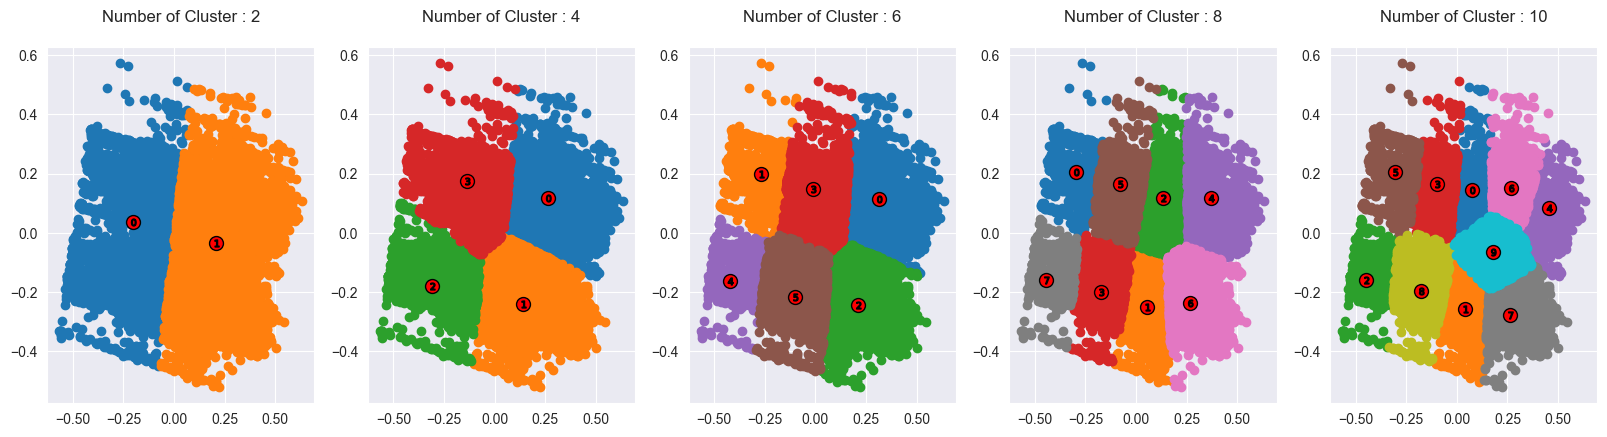

Combination [21]: em , OrdinalEncoder , RobustScaler


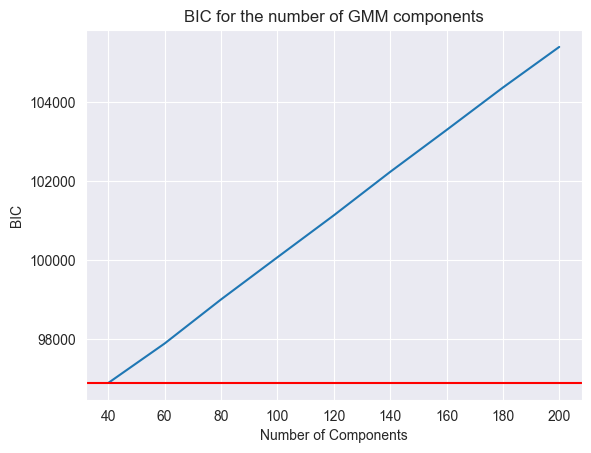

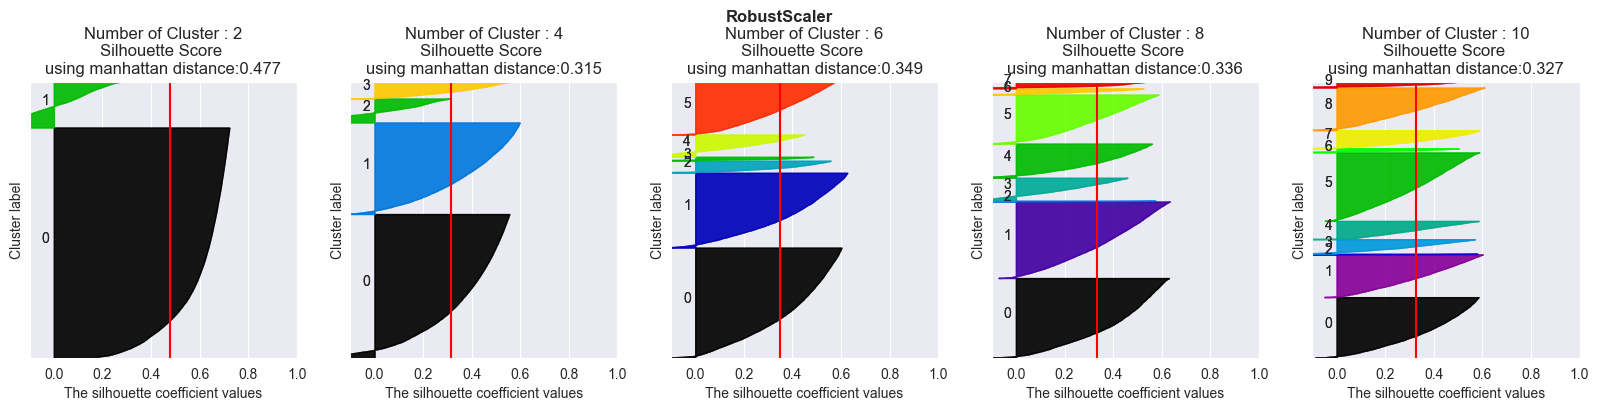

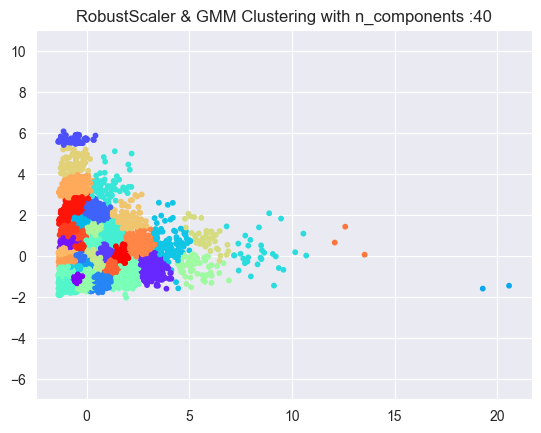

Combination [22]: clarans , OrdinalEncoder , RobustScaler
Combination [23]: dbscan , OrdinalEncoder , RobustScaler


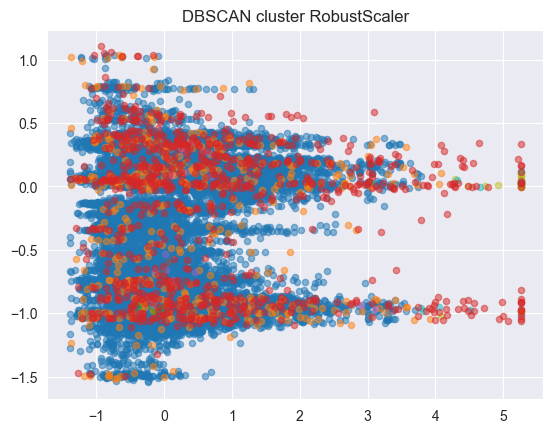

Combination [24]: kmeans , OrdinalEncoder , RobustScaler


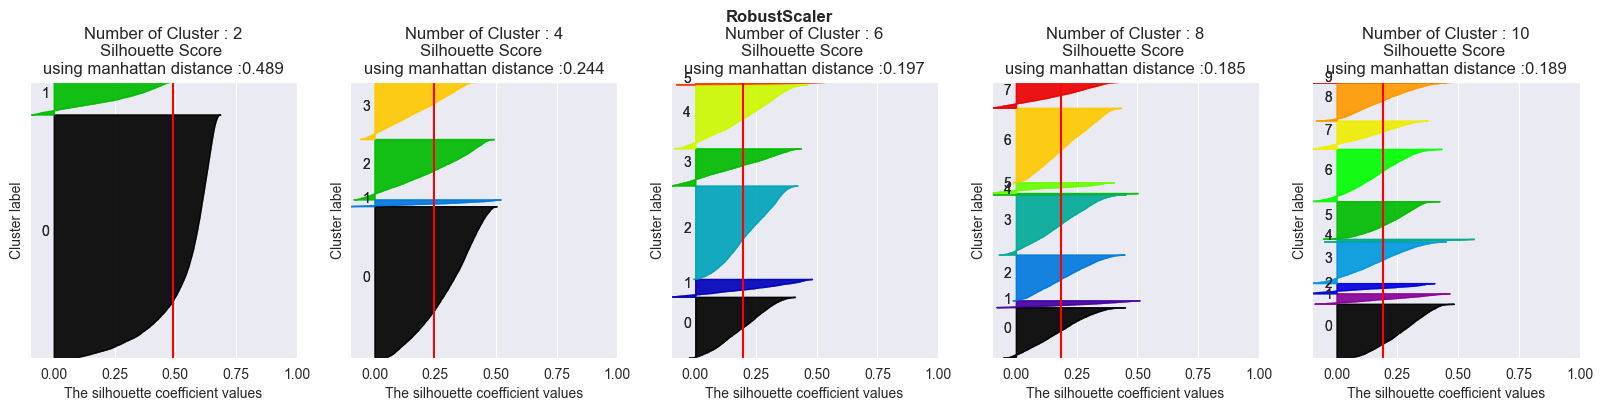

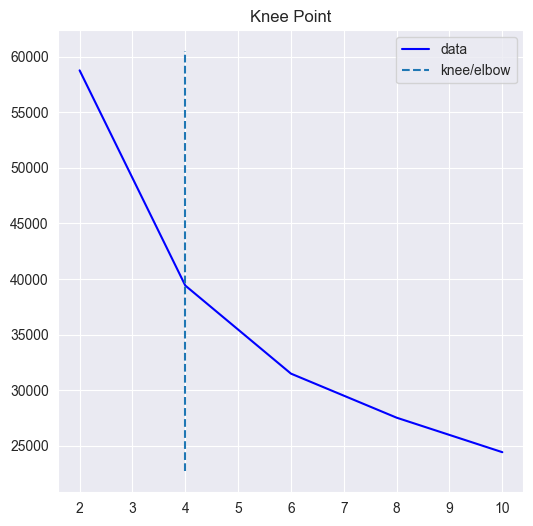

The elbow point is  4


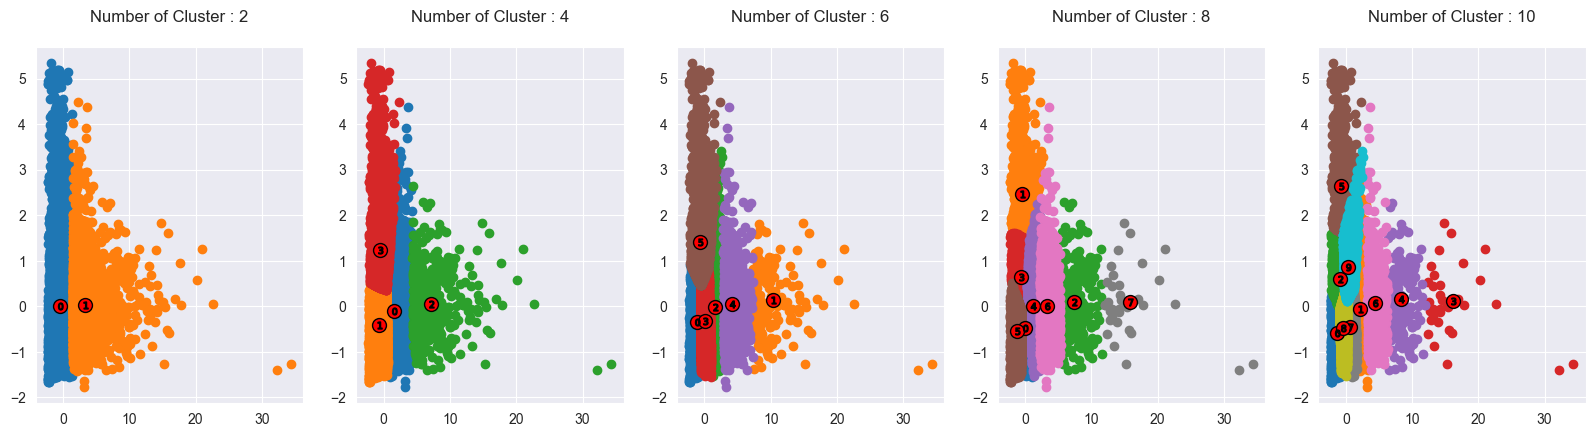

In [80]:
############################# main #############################
df_origin = data_reading()

plt.title('Amount Of Missing Values',fontsize=20)
ax = sns.heatmap(pd.DataFrame(df_origin.isna().sum()),annot=True,fmt='d')
plt.show()

# handling the missing value and check again
print("\n--------------- Drop NAN and check data ---------------\n")
df = df_origin.copy()
df = df.dropna()
print(df.isna().sum())

# "ocean_proximity' column has categorical data, so we need to handle this by encoding.
print("---------- ocean proximity ----------")
print(df['ocean_proximity'])
print()

# Using Label Encoder
encoder_lb = LabelEncoder()
df['ocean_proximity'] = encoder_lb.fit_transform(df['ocean_proximity'])

print("---------- After Encoding ----------")
print(df['ocean_proximity'])

# Get correlation between all features
plt.figure(figsize=(10,10))
sns.heatmap(data = df.corr(), annot=True,fmt = '.2f', linewidths=.5, cmap='Blues')
plt.show()


feature_combination_list = []
numeric_cols = list(df_origin.columns)
numeric_cols.remove('latitude')
numeric_cols.remove('longitude')
numeric_cols.remove('median_house_value')

# pick columns randomly
for i in range(4):
    selected_features = random.sample(numeric_cols, i + 2)
    feature_combination_list.append(selected_features)

for combination in feature_combination_list:
    dataset_x = df[combination]
    data_category = dataset_x.select_dtypes(include='object')


# List setting (Setting here ↓)
model_list = ['em', 'clarans', 'dbscan', 'kmeans']
encoder_list = ['LabelEncoder', 'OrdinalEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler','RobustScaler']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df_origin.sample(n=int(df_origin.shape[0] * 0.01), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list,
               scaling_lists=scaling_list,
               select_feature_lists=feature_combination_list)